This project uses data related to the Electric Production from 1985 to 2017 and aims to develop ML algorithms for prediction and forecasting (SARIMAX and LSTM)<br>

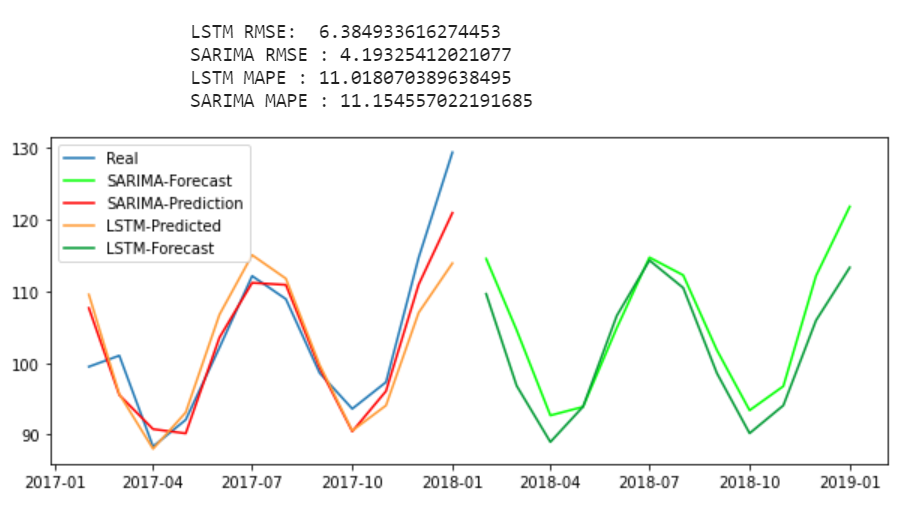
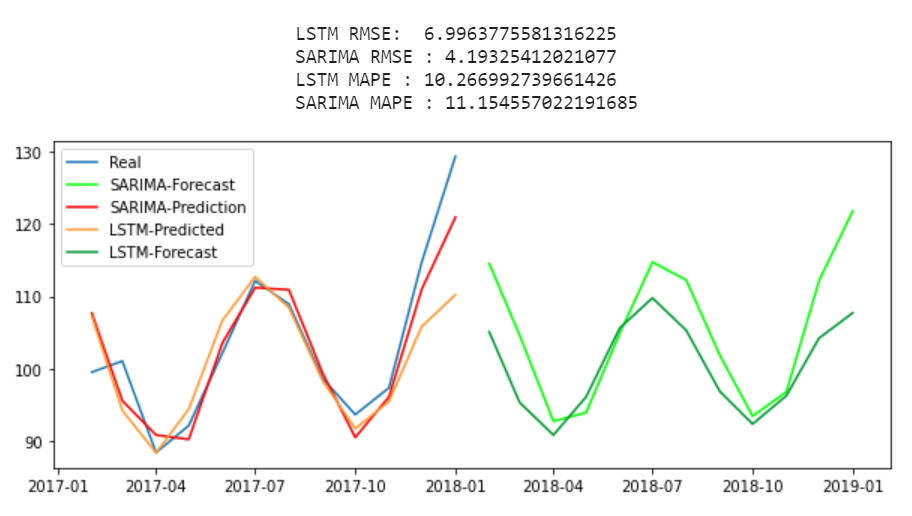

The results look indeed very similar both in terms of rmse and mape.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df=pd.read_csv('/kaggle/input/time-series-datasets/Electric_Production.csv', index_col='DATE', parse_dates=True)

In [ ]:
df.head()

In [ ]:
df.columns = ['value']

In [ ]:
df.tail()

In [ ]:
df.info()

There are no missing values!

In [ ]:
df.plot()

The data can be interpreted as a time series with a clear positive trend and seasonality.<br>
In the following, aprediction model by LSTM RNN and SARIMAX will be developed to forecast the time series.

# LSTM RNN model


When modeling a time series by LSTM RNN, it is crucial to to properly shape the input data in a sliding windows format.

First, we need to specify the prediciton window. In this application, the data is given as monthly data. So, for example, we can use a 12 steps prediction window. This means that we use 12 samples of data (data of an entire year) to predict the 13th sample.

In [ ]:
prediction_windows=12

Now we can split the data into a train and test set. In particular, this means that the train set will have 397-12=385 samples, while the test set only the last 12 values.

In [ ]:
train=df.iloc[:len(df)-prediction_windows]
test=df.iloc[len(df)-prediction_windows:]

In the following, since we will use a RNN, it is recommended to rescale the data.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler=MinMaxScaler()

In [ ]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
n_input=12 #Use 12 months data to predict 13 th month data
n_features=1 # we are dealing with an univariate time series, so n_features should be set to 1. 
#In case of a multivariate time series, n_features should be set to a proper value higher than 1.

Now we can formally create the train set. As stated before, the train set will have a "sliding window" shape. This means that we have to shape the data in such a way that the RNN will predict the 13th sample starting from the previous from 12 samples.

In [ ]:
X_train=[]
y_train=[]
for i in range(n_input,len(scaled_train)):
    X_train.append(scaled_train[i-n_input:i])
    y_train.append(scaled_train[i])
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
print(f'Given the Array: \n {X_train[0].flatten()}')
print(f'Predict this value: \n {y_train[0]}')

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [ ]:
# define model
model = Sequential()
model.add(LSTM(100, input_shape=(n_input, n_features), return_sequences=True))
#model.add(Dropout(0.2))
model.add(LSTM(20, input_shape=(n_input, n_features), return_sequences=False))
#model.add(Dropout(0.4))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

In [ ]:
model.fit(X_train, y_train, epochs=100)

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

# LSTM Prediction

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:] # use the previous 12 samples to predict the 13th
current_batch=first_eval_batch.reshape((1,n_input,n_features)) # reshape the data into (1,12,1)
for i in range(len(test)):
    #get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    #append the prediction into the array
    test_predictions.append(current_pred)
    
    #use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
test['Predictions'] = true_predictions

In [ ]:
test.plot(figsize=(12,5))

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_lstm=sqrt(mean_squared_error(test['value'],test['Predictions']))
print(rmse_lstm)

In [ ]:
pred_dates=np.asarray(test.index)
dates=np.asarray(df.index)

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(pred_dates,test['Predictions'].values,color='red',label='Predicted')
plt.plot(dates,df.values, label='Real')
plt.legend()
plt.show()

To check the performance of the algorithm, we will also define a MAPE (Mean absolute percentage error) function that returns the MAPE.

In [ ]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [ ]:
mape_lstm=mape(df.values[-12:], test['Predictions'].values)
mape_lstm

# LSTM FORECAST

We can use the developed LSTM RNN to forecast the data. <br>
First, we need to create a new vector with the indeces of the forecast days. In this case, we choose to forecast the data for 12 months.

In [ ]:
date_offset=12
forecast_dates =  (df.index + pd.DateOffset(months=date_offset))[-date_offset:]
forecast_dates

In [ ]:
forecast=[]

first_eval_batch = test_predictions[-n_input:] #use the past 12 values of the predicted values to forecast
current_batch=np.reshape(first_eval_batch,(1,n_input,n_features))

for i in range(date_offset):
    #get the prediction alue for the first batch
    current_pred = model.predict(current_batch)[0]
    
    #append the prediction into the array
    forecast.append(current_pred)
    
    #use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

In [ ]:
true_forecast= scaler.inverse_transform(forecast)

In [ ]:
df_forecast=pd.DataFrame({'date': forecast_dates})
df_forecast.set_index('date', inplace=True)
df_forecast['forecast']=true_forecast
df_forecast.head()

In [ ]:
df_forecast.plot(figsize=(10,4))

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(dates,df.values, label='Real')
plt.plot(pred_dates,test['Predictions'].values,color='red',label='Predicted')
plt.plot(forecast_dates,df_forecast['forecast'].values, color='green', label='Forecast')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(dates[-12:],df[-12:].values, label='Real')
plt.plot(pred_dates,test['Predictions'].values,color='red',label='Predicted')
plt.plot(forecast_dates,df_forecast['forecast'].values, color='green', label='Forecast')
plt.legend()
plt.show()

# SARIMA model

In the following,the time series will be modeled by as a SARIMA model.

We can use some useful tools such as 'seasonal decompose' to better visualize the time series.

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df)

fig = plt.figure()  
fig = result.plot()

We can also check the stationarity of the time serie by performing the Augmented Dickey Fuller (ADF) test.

In [ ]:
from statsmodels.tsa.stattools import adfuller
result=adfuller(df.value.dropna())
print(f'ADF Statistics:{result[0]}')
print(f'p-value:{result[1]}')

The p-value is higher than 0.05. This means that the time serie is non stationary with a confidence of 95%. We check if with a one step differentiation, the time serie become stationary (in terms of a trendless time series).

In [ ]:
result=adfuller(df.value.diff().dropna())
print(f'ADF Statistics:{result[0]}')
print(f'p-value:{result[1]}')

Now the series looks stationary with a 1-order difference

## ACF AND PACF

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
fig, (ax1, ax2)=plt.subplots(2,1,figsize=(8,8))

plot_acf(df,lags=14, zero=False, ax=ax1)
plot_pacf(df,lags=14, zero=False, ax=ax2)
plt.show()

The series looks indeed non stationary

## AUTO ARIMA

In [ ]:
!pip install pmdarima
import pmdarima as pm

In [ ]:
results=pm.auto_arima(df, d=1, start_p=1, start_q=1, max_p=3, max_q=3,
                    seasonal=True, m=6, D=1, start_P=1, start_Q=1, max_P=2, max_Q=2, information_criterion='aic', trace=True, error_action='ignore', stepwise=True)

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model=SARIMAX(df,order=(2,1,2),  seasonal_order=(1, 1, 2, 6))
results=model.fit()

In [ ]:
results.summary()

In [ ]:
# Create the 4 diagostics plots
results.plot_diagnostics(figsize=(8,8))
plt.show()

All the 4 plots indicates a good fit of the SARIMA model on the given time serie.

# SARIMA PREDICTION

Now we will create a vector that will host the predictions

In [ ]:
prediction = results.get_prediction(start=-12)
mean_prediction=prediction.predicted_mean

Moreover, we also get the confidence intervals from the sarima prediction

In [ ]:
confi_int_p=prediction.conf_int()
lower_limits_p=confi_int_p.iloc[:,0]
upper_limits_p=confi_int_p.iloc[:,1]

In [ ]:
pred_dates=np.asarray(mean_prediction.index)
dates=np.asarray(df.index)

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(pred_dates,mean_prediction.values,color='red',label='prediction')
plt.fill_between(pred_dates, lower_limits_p, upper_limits_p, color='pink')
plt.plot(dates,df.values, label='real')
plt.legend()
plt.show()

In [ ]:
mape_sarima = mape(df[-12:].values,mean_prediction.values)

In [ ]:
rmse_sarima = sqrt(mean_squared_error(df[-12:].values,mean_prediction.values))
print(rmse_sarima)

# SARIMA FORECAST

In [ ]:
# Make ARIMA forecast of next 10 values
forecast = results.get_forecast(steps=12)
mean_forecast=forecast.predicted_mean
mean_forecast.size

In [ ]:
confi_int_f=forecast.conf_int()
lower_limits_f=confi_int_f.iloc[:,0]
upper_limits_f=confi_int_f.iloc[:,1]

In [ ]:
forec_dates=np.asarray(mean_forecast.index)
pred_dates=np.asarray(mean_prediction.index)
dates=np.asarray(df.index)
plt.figure(figsize=(10,4))
plt.plot(forec_dates,mean_forecast.values,color='green',label='forecast')
plt.fill_between(forec_dates, lower_limits_f, upper_limits_f, color='lightgreen')

plt.plot(pred_dates,mean_prediction.values,color='red',label='prediction')
plt.fill_between(pred_dates, lower_limits_p, upper_limits_p, color='pink')

plt.plot(dates,df.values, label='real')
plt.legend(loc='upper left')
plt.show()

# Results Sumamry

In [ ]:
print('LSTM RMSE: ', rmse_lstm)
print('SARIMA RMSE :', rmse_sarima)
print('LSTM MAPE :', mape_lstm)
print('SARIMA MAPE :', mape_sarima)

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(dates[-12:],df[-12:].values, label='Real') 
plt.plot(forec_dates,mean_forecast.values,color='#00ff00',label='SARIMA-Forecast')
plt.plot(pred_dates,mean_prediction.values,color='#ff0000',label='SARIMA-Prediction')
plt.plot(pred_dates,test['Predictions'].values,color='#ff9933',label='LSTM-Predicted')
plt.plot(forecast_dates,df_forecast['forecast'].values, color='#009933', label='LSTM-Forecast')
plt.legend(loc='upper left')
plt.show()